In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
!ls

Whatsapp_chat_analysis.ipynb chats.csv
_chat.txt                    word_cloud.png


In [3]:
import re
pattern = r'\[(\d+\/\d+\/\d+,\s\d+:\d+:\d+)\]\s(\w+)\:(.*)'
with open('_chat.txt','r') as f:
    chats = re.findall(pattern, f.read())
    
chats = pd.DataFrame(chats, columns = ['DateTime', 'Sender', 'Msg'])
chats.to_csv('chats.csv', index = False)


In [4]:
from datetime import datetime
from dateutil.parser import parse

chats['DateTime'] = [parse(x,dayfirst= True) for x in chats['DateTime']]

In [5]:
len(chats)


3496

In [6]:
chats.head(2)

,DateTime,Sender,Msg
0,2017-11-06 09:28:29,Matt,‎Messages to this chat and calls are now secu...
1,2017-11-06 09:28:44,Michelle,Hi


In [7]:
start = chats['DateTime'][0]
end = chats['DateTime'][len(chats)-1]
chat_period = end-start
total_chats = len(chats)
average_chat_num = total_chats/chat_period.days
print('We have been talking on Whatsapp since {}. It has been {} days till {}.\n'\
      .format(start, chat_period.days, end)) 
print('We have sent each other {} messages in total, on average {:.0f} messages a day.'\
     .format(total_chats, average_chat_num))

We have been talking on Whatsapp since 2017-11-06 09:28:29. It has been 125 days till 2018-03-11 23:27:08.

We have sent each other 3496 messages in total, on average 28 messages a day.


In [8]:
from nltk.tokenize import word_tokenize
#eliminate all non-alphabetical characters, hyperlinks, and stopwords, omitted image
from nltk.corpus import stopwords
stopWords = stopwords.words('english') # remove stopwords
dropWords = ['','omitted','image','yeah','sounds','good','ok','sure','like'] + stopWords # remove common response words
def preprocess(chats):
    message = []
    for chat in chats:
        chat = word_tokenize(chat)
        chat = [token.lower() for token in chat]
        chat = [re.sub(r'[\d\W\?\.,!]','',token) for token in chat]
        chat = [re.sub(r'\bnt\b', 'not', token) for token in chat]
        chat = [token for token in chat if token not in dropWords]
        message.append(chat)
    return message
chat_copy = chats['Msg'].copy
chat_copy = preprocess(chats['Msg'])
chats['Msg'] = chat_copy    

In [9]:
chats['Msg'].head(3)

0    [messages, chat, calls, secured, endtoend, enc...
1                                                 [hi]
2            [ah, looking, whatsapp, contacts, hahaha]
Name: Msg, dtype: object

In [10]:
Michelle = chats[chats['Sender'] == 'Michelle']
Matt = chats[chats['Sender'] == 'Matt']
print('Michelle have sent {} messages to Matt; Matt have sent {} messages to Michelle.'.format(len(Michelle), len(Matt)))

Michelle have sent 1725 messages to Matt; Matt have sent 1771 messages to Michelle.


In [11]:
from collections import Counter
def mergeMsg(Msg):
    mergedMsg = []
    for msg in Msg:
        mergedMsg += msg
    return mergedMsg


In [12]:
from collections import Counter
Matt_Msg = mergeMsg(Matt['Msg'])
Matt_word_counts = Counter(Matt_Msg)
Michelle_Msg = mergeMsg(Michelle['Msg'])
Michelle_word_counts = Counter(Michelle_Msg)

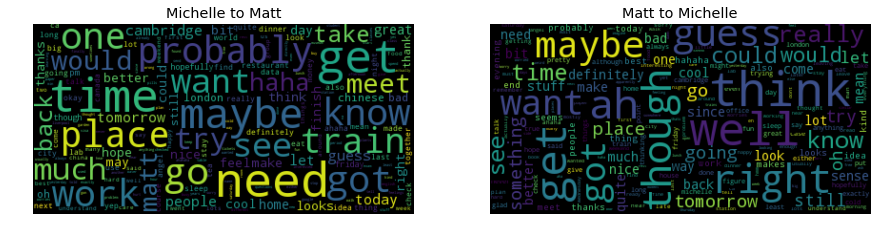

In [139]:
from wordcloud import WordCloud

# lower max_font_size
wordcloud_Michelle = WordCloud(max_font_size=50).generate_from_frequencies(Michelle_word_counts)
wordcloud_Matt = WordCloud(max_font_size=50).generate_from_frequencies(Matt_word_counts)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.imshow(wordcloud_Michelle, interpolation="bilinear")
ax2.imshow(wordcloud_Matt, interpolation="bilinear")
ax1.axis("off")
ax2.axis("off")
ax1.set_title("Michelle to Matt")
ax2.set_title("Matt to Michelle")
plt.savefig('word_cloud.png', dpi = 300,  bbox_inches='tight')

In [28]:
ts = pd.Series(np.ones(len(chats)), index = chats['DateTime'])
ts_michelle = pd.Series(np.ones(len(Michelle)), index = Michelle['DateTime'])
ts_matt = pd.Series(np.ones(len(Matt)), index = Matt['DateTime'])

                                        

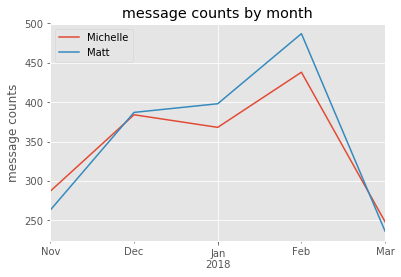

In [137]:
month_michelle = ts_michelle.resample('M', kind = 'period').sum() # aggregate data by month
month_matt = ts_matt.resample('M', kind = 'period').sum()
plt.figure()
ax1 = month_michelle.plot(label = 'Michelle')
ax2 = month_matt.plot(label = 'Matt')
plt.ylabel('message counts')
plt.title('message counts by month')
plt.xlabel('')
plt.legend()
plt.savefig('message_counts_by_month.png')

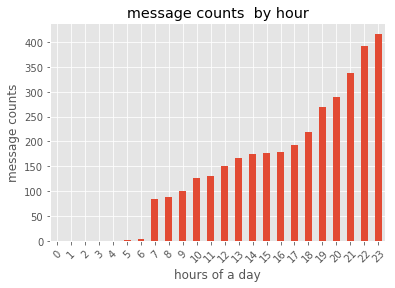

In [135]:
time =[ datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour for x in chats['DateTime']] 
#time = chats['DateTime'].values.time()
hour_counts = np.array([x for x in Counter(time).items()])
for i in range(23):
    if i not in list(hour_counts[:,0]):
        hour_counts = np.append(hour_counts, [[i, 0]], axis = 0)
hour_counts = np.sort(hour_counts, axis =0)
hour_counts_pd = pd.Series(hour_counts[:,1], index = hour_counts[:,0])

plt.figure()
hour_counts_pd.plot.bar()
plt.xlabel('hours of a day')
plt.xticks(rotation = 45)
plt.ylabel('message counts')
plt.title('message counts  by hour')
plt.savefig('message_counts_by_hour.png')